
Goal right now:
1. write API for calling probes on layers
    done.
2. run probes on pretrained models.
2. implement LEACE 
3. test the utility of the algorithm, post LEACE and pre-LEACE, on each class.
    1. plot the new error - old error, for each class 


1. test that when you have better points for probes.
2. test that if you only run probe post layer `l`, where `l` is the layer that achieves above some probe accuracy
3. 

Using device: cuda
Generated data shape: torch.Size([500, 5])
Covariance matrix:
 tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.2500, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.1111, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0625, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0400]], device='cuda:0')


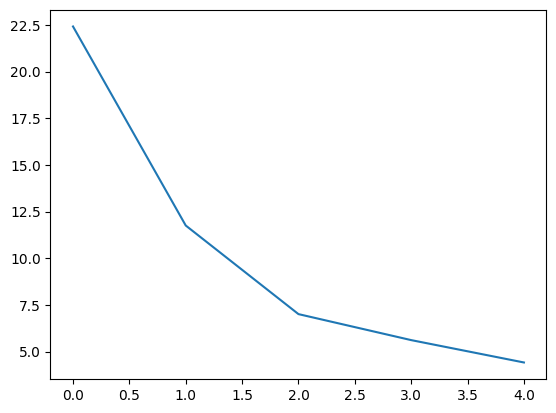

In [1]:
import torch
from importlib import reload 
from pathlib import Path 

from unlearning.datasets import gaussian 

BASE_DIR = Path("/n/home04/rrinberg/data_dir__sneel/Lab/rrinberg/results")

# Example usage:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

n_samples = 500

n_features = 5
alpha = 2  # Adjust alpha to change the rate of decay

# Generate the dataset and obtain the covariance matrix used
data, cov_matrix = gaussian.generate_powerlaw_gaussian_dataset(n_samples, n_features, alpha=alpha, device=device, mean = 2.)

print("Generated data shape:", data.shape)
print("Covariance matrix:\n", cov_matrix)

# Compute the empirical covariance matrix of the generated data for verification
data_centered = data - data.mean(dim=0, keepdim=True)
emp_cov = torch.mm(data_centered.t(), data_centered) / (n_samples - 1)

# Print the empirical covariance matrix
U, S, V = torch.svd(data_centered)
# plot S
import matplotlib.pyplot as plt
plt.plot(S.cpu().numpy())
plt.show()

Using device: cuda
X shape: torch.Size([1000, 2])
Covariance of the whitened data:
 tensor([[9.9999e-01, 4.3426e-06],
        [4.3426e-06, 9.9998e-01]], device='cuda:0')


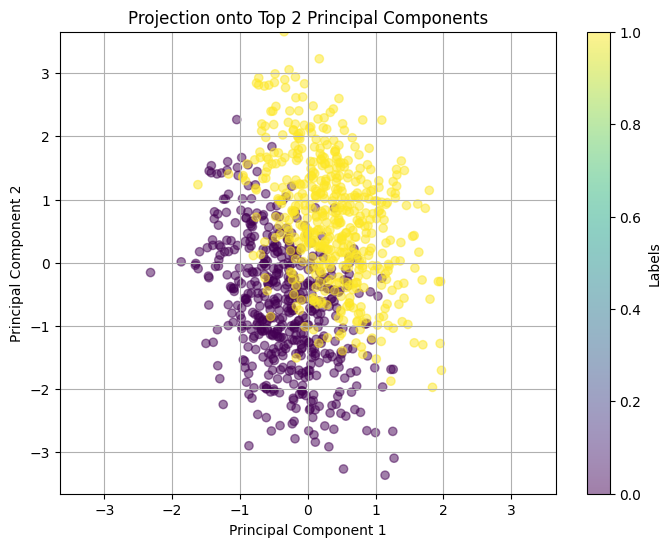

Variance of original data: tensor([1.3752, 0.5668], device='cuda:0')


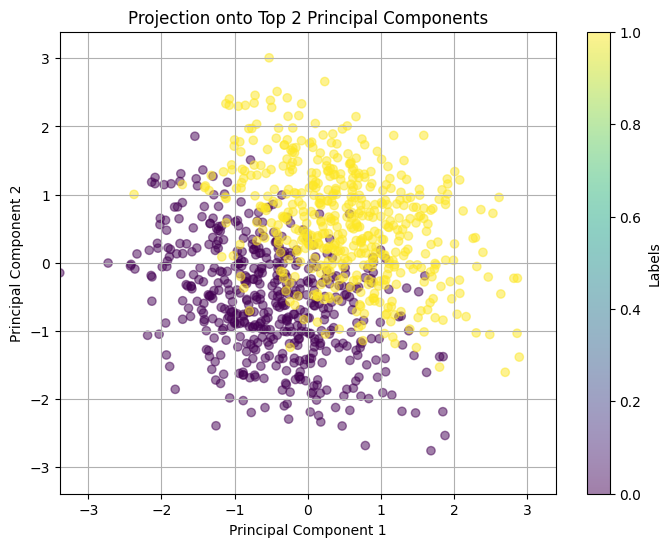

Covariance of whitened data: tensor([[1., 0.],
        [0., 1.]], device='cuda:0')
Variance of original data: tensor([1.0000, 1.0000], device='cuda:0')


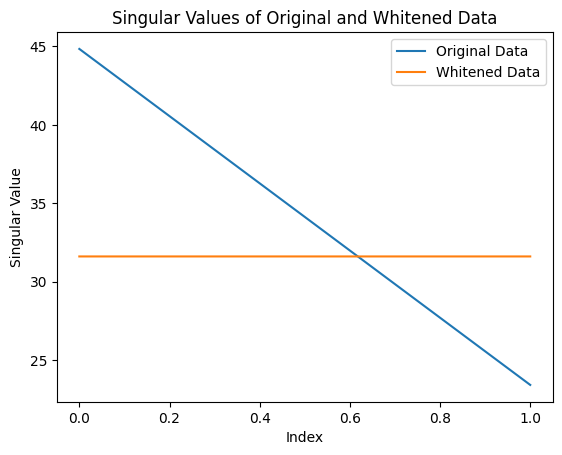

In [5]:
import torch
import matplotlib.pyplot as plt


from unlearning import probes, leace, plotting
reload(probes)
reload(plotting)
reload(leace)
# Select device: use CUDA if available, otherwise CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

# Create a random dataset with 100 samples and 5 features on the selected device
torch.manual_seed(42)

n_samples = 500
n_features = 2
alpha = 2  # Adjust alpha to change the rate of decay
difference = 1.1

# Generate the dataset and obtain the covariance matrix used
X1, cov_matrix = gaussian.generate_powerlaw_gaussian_dataset(n_samples, n_features, alpha=alpha, device=device)
X2, cov_matrix = gaussian.generate_powerlaw_gaussian_dataset(n_samples, n_features, alpha=alpha, device=device, mean = difference)

data = torch.cat((X1, X2), dim=0)

labels = torch.zeros(len(data))
labels[len(X1):] = 1

print(f"X shape: {data.shape}")    
# Whiten the dataset
X_white = leace.whiten_data_torch(data)

# Verify that the covariance of the whitened data is approximately the identity matrix
n_samples = X_white.size(0)
cov_whitened = torch.mm(X_white.T, X_white) / (n_samples - 1)
print("Covariance of the whitened data:\n", cov_whitened)

# Optionally, generate some dummy labels (e.g., for binary classes)
#labels = torch.randint(0, 2, (n_samples,), device=device)

# plot original data with top pcs

plotting.plot_top2_pcs_torch(data, labels=labels)
var_orig = torch.var(data, dim=0)
print(f"Variance of original data: {var_orig}")
# plot whitened data
plotting.plot_top2_pcs_torch(X_white, labels=labels)
var_whitened = torch.var(X_white, dim=0)
covar_whitened = torch.cov(X_white.T)
# round covar_whitened to 2 decimal places
covar_whitened = torch.round(covar_whitened * 100) / 100
print(f"Covariance of whitened data: {covar_whitened}")
print(f"Variance of original data: {var_whitened}")

# plot the covariance matrix of the whitened data
U, S, V = torch.svd(data)
U_whitened, S_whitened, V_whitened = torch.svd(X_white)     
plt.plot(S.cpu().numpy(), label='Original Data')
plt.plot(S_whitened.cpu().numpy(), label='Whitened Data')
plt.xlabel('Index')
plt.ylabel('Singular Value')
plt.title('Singular Values of Original and Whitened Data')
plt.legend()
plt.show()


## example model to probe 
(note: probe should attain same level of accuracy as the model itself, as both are linear)

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim

# Create a simple synthetic dataset
# We'll create two clusters in 2D space:
# - Cluster for class 0 centered at (-1, -1)
# - Cluster for class 1 centered at (1, 1)
torch.manual_seed(42)

dim = data.shape[1]

# Define the Logistic Regression model
class LogisticRegression(nn.Module):
    def __init__(self, input_dim):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(input_dim, 1)  # single output for binary classification

    def forward(self, x):
        # Apply linear transformation followed by a sigmoid activation
        x= x.float()
        return torch.sigmoid(self.linear(x))

# x to float
X = data.float()
labels = labels.float()
model = LogisticRegression(dim)
# model to device
model.to(device)
labels = labels.to(device)
X = X.to(device)
# Define the loss function and the optimizer
criterion = nn.BCELoss()  # Binary Cross Entropy Loss
optimizer = optim.SGD(model.parameters(), lr=0.1)

# Training loop
num_epochs = 1000
for epoch in range(num_epochs):
    # Forward pass: compute predicted y by passing X to the model
    outputs = model(X).squeeze()  # squeeze to remove extra dimensions
    loss = criterion(outputs, labels)
    
    # Zero gradients, perform backward pass, and update weights.
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # Print loss every 100 epochs
    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

# Evaluate the trained model
with torch.no_grad():
    predictions = (model(X).squeeze() >= 0.5).float()  # threshold at 0.5 for binary classification
    accuracy = (predictions == labels).float().mean()
    print(f'Accuracy: {accuracy.item() * 100:.2f}%')


Epoch [100/1000], Loss: 0.3723
Epoch [200/1000], Loss: 0.3292
Epoch [300/1000], Loss: 0.3086
Epoch [400/1000], Loss: 0.2970
Epoch [500/1000], Loss: 0.2898
Epoch [600/1000], Loss: 0.2850
Epoch [700/1000], Loss: 0.2816
Epoch [800/1000], Loss: 0.2792
Epoch [900/1000], Loss: 0.2774
Epoch [1000/1000], Loss: 0.2761
Accuracy: 88.50%


Processing sample 0
Processing sample 50
Processing sample 100
Processing sample 150
Processing sample 200
Processing sample 250
Processing sample 300
Processing sample 350
Processing sample 400
Processing sample 450
Processing sample 0
Processing sample 50
Processing sample 100
Processing sample 150
Processing sample 200
Processing sample 250
Processing sample 300
Processing sample 350
Processing sample 400
Processing sample 450
probe_dataset shape: torch.Size([1000, 2])
probe_dataset shape: torch.Size([1000, 2])
Epoch [100/1000], Loss: 0.4222
Epoch [200/1000], Loss: 0.3483
Epoch [300/1000], Loss: 0.3183
Epoch [400/1000], Loss: 0.3027
Epoch [500/1000], Loss: 0.2934
Epoch [600/1000], Loss: 0.2874
Epoch [700/1000], Loss: 0.2833
Epoch [800/1000], Loss: 0.2804
Epoch [900/1000], Loss: 0.2783
Epoch [1000/1000], Loss: 0.2768
Accuracy: 88.50%
88.50000500679016
probe_dataset.shape - torch.Size([1000, 2])


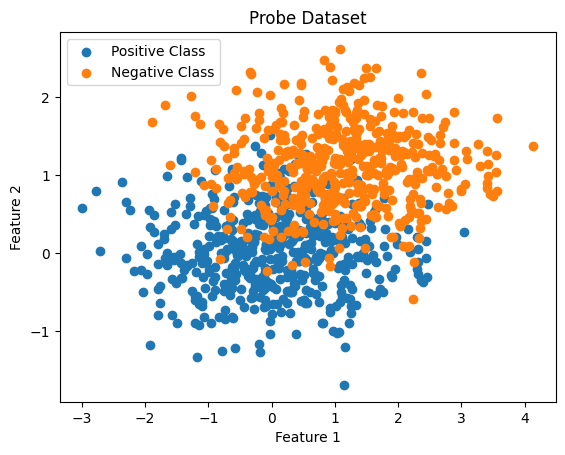

In [11]:
# run linear probe from probes
from unlearning import probes
reload(probes)
#layer_ind = probes.get_layer_count(model) - layer_from_end
pos_points = X1
neg_points = X2
(probe_acc, probe_model), (probe_dataset, probe_labels)= probes.linear_probe(model=model, layer_ind = 0, pos_points=pos_points, neg_points=neg_points, device=device)
print(probe_acc)


from matplotlib import pyplot as plt
import numpy as np
reload(probes)

# plot probe_dataset

print(f"probe_dataset.shape - {probe_dataset.shape}")
pos_probe_pts_inds = np.where(probe_labels == 1)[0]
neg_probe_pts_inds = np.where(probe_labels == 0)[0]
plt.scatter(probe_dataset[pos_probe_pts_inds, 0].cpu(), probe_dataset[pos_probe_pts_inds, 1].cpu(), label='Positive Class')
plt.scatter(probe_dataset[neg_probe_pts_inds, 0].cpu(), probe_dataset[neg_probe_pts_inds, 1].cpu(), label='Negative Class')
plt.legend()
plt.title('Probe Dataset')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()



okay, now that a linear probe is set up, let's test the accuracy on different layers in a real model
# setting up a real model 

In [16]:

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision.datasets import CelebA
import torchvision.datasets as datasets

from torch.utils.data import DataLoader
import torch.nn.functional as F
from tqdm import tqdm
import numpy as np 

from torch.utils.data import DataLoader, Subset
import json
import yaml  
def save_yaml(params, filename):
    with open(filename, 'w') as file:
        yaml.dump(params, file)

import pickle 
def save_pickle(params, filename):
    with open(filename, 'wb') as file:
        pickle.dump(params, file)
from pathlib import Path    


def load_model(attr_index, models_dir, trial = 1, DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")):

    SAVE_MODEL_PATH = f"resnet50_celeba__remove__{attr_index}__{trial}.pth"
    # resnet50_celeba__remove__31__0
    model_path = models_dir / SAVE_MODEL_PATH
    if not model_path.exists():
        raise ValueError(f"Model not found at {model_path}")
    
    model_without_attr = models.resnet50(pretrained=False)  # Train from scratch
    num_ftrs = model_without_attr.fc.in_features
    model_without_attr.fc = nn.Linear(num_ftrs, 40)  # Modify final layer for 40 attributes
    model_without_attr = model_without_attr.to(DEVICE)

    model_without_attr.load_state_dict(torch.load(model_path))
    
    return model_without_attr


# validate the model on val set
from tqdm import tqdm   
def evaluate(model, dataloader):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in tqdm(dataloader):
            images, labels = images.to(DEVICE), labels.float().to(DEVICE)
            logits = model(images)
            probs = torch.sigmoid(logits)  # Convert logits to probabilities
            preds = (probs > 0.5).int()  # Threshold at 0.5 to get binary predictions

            all_preds.append(preds)
            all_labels.append(labels)

    # Concatenate all predictions and labels
    preds = torch.cat(all_preds).cpu()
    labels = torch.cat(all_labels).cpu()
    return preds, labels


def get_TP_TN_FP_FN(col_ind, labels, predictions):
    # Get the false positives and false negatives for a specific attribute
    # where labels[:, col_ind] == 0 and predictions[:, col_ind] == 1
    FP = ((labels[:, col_ind] == 0) & (predictions[:, col_ind] == 1)).sum()
    FN = ((labels[:, col_ind] == 1) & (predictions[:, col_ind] == 0)).sum()
    TP = ((labels[:, col_ind] == 1) & (predictions[:, col_ind] == 1)).sum()
    TN = ((labels[:, col_ind] == 0) & (predictions[:, col_ind] == 0)).sum()
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0 
    return (TP, TN, FP, FN), (precision, recall)



DATA_DIR = Path("/n/home04/rrinberg/data_dir/data_to_concept/")

# ========================
# 2. DATA LOADING
# ========================
transform = transforms.Compose([
    #transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(),  # Augmentation: Flip images randomly
    transforms.RandomRotation(10),  # Augmentation: Small rotations
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),  # Color jittering
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

#train_dataset = CelebA(root=DATA_DIR, split="train", transform=transform, download=True, target_type="attr")
val_dataset = CelebA(root=DATA_DIR, split="valid", transform=transform, download=True, target_type="attr")


BATCH_SIZE= 1024
    
#train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)



Files already downloaded and verified


/n/holylabs/LABS/vadhan_lab/Lab/rrinberg/envs/unlearning_3.10/lib/python3.10/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [18]:
print(f"load model:")
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# MPS device
if torch.backends.mps.is_available():
    DEVICE = torch.device("mps")
print("Using device:", DEVICE)


model = load_model(attr_index=1, models_dir=BASE_DIR / "models_without_labels__multiple", DEVICE = DEVICE)


print(f"evaluate model:")
all_preds, all_labels = evaluate(model, val_loader)



vals = [(get_TP_TN_FP_FN(i, all_labels, all_preds)[1]) for i in range(40)]



model_layer_count = probes.get_layer_count(model)
print(f"layer count - {model_layer_count}")

#

load model:
Using device: cuda


/n/holylabs/LABS/vadhan_lab/Lab/rrinberg/envs/unlearning_3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/n/holylabs/LABS/vadhan_lab/Lab/rrinberg/envs/unlearning_3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/tmp/ipykernel_2805150/2696099806.py:41: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In

evaluate model:


  0%|          | 0/20 [00:00<?, ?it/s]/n/holylabs/LABS/vadhan_lab/Lab/rrinberg/envs/unlearning_3.10/lib/python3.10/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 20/20 [00:49<00:00,  2.47s/it]


layer count - 10


In [51]:
# get probe accuracy 
attribute_index = 10
#train_labels = train_dataset.attr
val_labels = val_dataset.attr
# attribute names 
attr_names = val_dataset.attr_names
print(f"attribute of interest - {attr_names[attribute_index]}")

positive_attributes = val_labels[:, attribute_index] == 1
negative_attributes = val_labels[:, attribute_index] == 0


N = 1000

pos_indices = torch.where(positive_attributes)[0]
neg_indices = torch.where(negative_attributes)[0]

pos_indices = np.array(pos_indices)[:N]
neg_indices = np.array(neg_indices)[:N]
# shuffle pos_indices
np.random.shuffle(pos_indices)
np.random.shuffle(neg_indices)

print(f"putting together probe dataset")
pos_points = [val_dataset[i][0] for i in pos_indices]
neg_points = [val_dataset[i][0] for i in neg_indices]


# set up a probe dataset 
print(f"len pos_indices - {len(pos_indices)}")
print(f"len neg_indices - {len(neg_indices)}")
# shuffle neg_indices



attribute of interest - Blurry
putting together probe dataset


/tmp/ipykernel_2805150/2434085764.py:18: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  pos_indices = np.array(pos_indices)[:N]
/tmp/ipykernel_2805150/2434085764.py:19: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  neg_indices = np.array(neg_indices)[:N]


len pos_indices - 940
len neg_indices - 1000


In [54]:
# test linear probe accuracy
N = 1000

reload(probes)



#probe_dataset = probes.set_up_probe_dataset(model=model, layer_ind = model_layer_count - 2, pos_points=pos_points, neg_points=neg_points, device=DEVICE)

probe_ = probes.linear_probe(model=model, layer_ind = model_layer_count - 1, pos_points=pos_points, neg_points=neg_points, device=DEVICE)[0]

#print(f"probe acc - {probe_acc}")


Processing sample 0
Processing sample 50
Processing sample 100
Processing sample 150
Processing sample 200
Processing sample 250
Processing sample 300
Processing sample 350
Processing sample 400
Processing sample 450
Processing sample 500
Processing sample 550
Processing sample 600
Processing sample 650
Processing sample 700
Processing sample 750
Processing sample 800
Processing sample 850
Processing sample 900
Processing sample 0
Processing sample 50
Processing sample 100
Processing sample 150
Processing sample 200
Processing sample 250
Processing sample 300
Processing sample 350
Processing sample 400
Processing sample 450
Processing sample 500
Processing sample 550
Processing sample 600
Processing sample 650
Processing sample 700
Processing sample 750
Processing sample 800
Processing sample 850
Processing sample 900
Processing sample 950
probe_dataset shape: torch.Size([1940, 2048])
probe_dataset shape: torch.Size([1940, 2048])
Epoch [100/1000], Loss: 0.4956
Epoch [200/1000], Loss: 0

In [56]:
probe_[0]

87.21649646759033

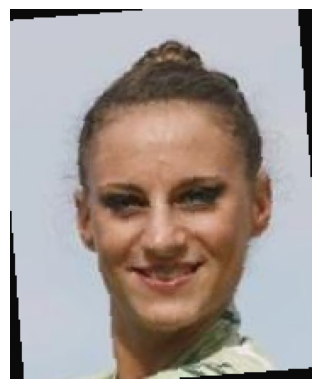

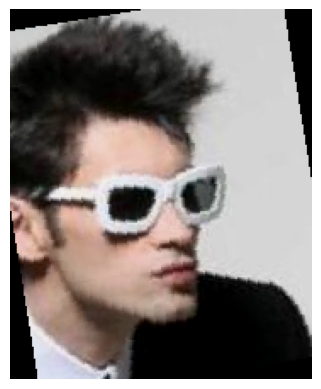

In [44]:
from unlearning import plotting
reload(plotting)

pos_index = pos_indices[0]
neg_index = neg_indices[0]

image_ = val_dataset[pos_index][0]
plotting.show_image(image_)

image_ = val_dataset[neg_index][0]
plotting.show_image(image_)